<a href="https://colab.research.google.com/github/shantanu4u/DataQuality/blob/main/2020FC04832_Dissertation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The process to find duplicate data or Matched record :

1.	Pre-processing
  *   input: dataset 
  *   output: cleaned dataset
2.	Indexing
  *   output: pairs to compare
3.	Comparison
  *   output: comparison vectors
4.	Classification
  *   output: matching/nonmatching pairs
5.	Clustering 
  *   output: unique record clusters


Install necessary packages

In [1]:
!pip install recordlinkage


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import recordlinkage
import pandas as pd
from recordlinkage.datasets import load_febrl2
df = load_febrl2()
df

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
rec_id,,,,,,,,,,
rec-2778-org,sarah,bruhn,44,forbes street,wintersloe,kellerberrin,4510,vic,19300213,7535316
rec-712-dup-0,jacob,lanyon,5,milne cove,wellwod,beaconsfield upper,2602,vic,19080712,9497788
rec-1321-org,brinley,efthimiou,35,sturdee crescent,tremearne,scarborough,5211,qld,19940319,6814956
rec-3004-org,aleisha,hobson,54,oliver street,inglewood,toowoomba,3175,qld,19290427,5967384
rec-1384-org,ethan,gazzola,49,sheaffe street,bimby vale,port pirie,3088,sa,19631225,3832742
...,...,...,...,...,...,...,...,...,...,...
rec-1487-org,thomas,green,44,tuthill place,holmeleigh,bonny hills,4740,vic,19420210,9334580
rec-1856-org,james,mcneill,42,archibald street,NaN,evans head,2250,nsw,19011207,4837378
rec-3307-org,paige,lock,7,a'beckett street,camboon,carina heights,2290,nsw,19871002,5142242


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, rec-2778-org to rec-1143-org
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   given_name     4891 non-null   object
 1   surname        4936 non-null   object
 2   street_number  4777 non-null   object
 3   address_1      4891 non-null   object
 4   address_2      4431 non-null   object
 5   suburb         4950 non-null   object
 6   postcode       5000 non-null   object
 7   state          4952 non-null   object
 8   date_of_birth  4890 non-null   object
 9   soc_sec_id     5000 non-null   object
dtypes: object(10)
memory usage: 429.7+ KB


From the statistical summary results below, we can quickly see that the unique count for the surname, given_name is not 5000, which indicates that there are possibilities that the same person could have multiple records in the data set with different addresses/streets number/states, etc

In [4]:
df.describe()

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
count,4891,4936,4777,4891,4431,4950,5000,4952,4890,5000
unique,907,1816,397,2455,2517,1684,1412,19,3785,4089
top,emiily,white,1,forbes street,rosetta village,toowoomba,4701,nsw,19920917,1135598
freq,85,131,142,16,40,46,23,1604,7,6


### Applying Record Linkage Process
Process to perform record linkage

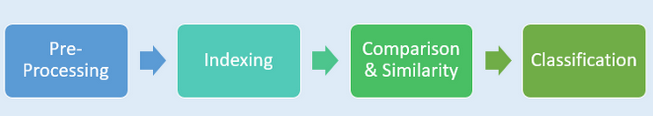

### What is Record Linkage?

Record Linkage refers to the method of identifying and linking records that correlates with the same entity (Person, Business, Product,….) within one or across several data sources. It searches for possible duplicate records and links them together to be treated as a single record, which also makes it possible to avoid data redundancy.

When unique identifiers variables are present in the data sets such as ( Identification numbers, hash codes, etc), the process of linking the same entity will be simple. However, there are cases where unique identifiers are not present in the data sets, therefore we will then need to identify good candidates of variables that are being duplicated and pair them up (eg: State, Last Name, Date of Birth, Phone No)

### Pre-processing
Lowercase / Uppercase

In [5]:
df = df.astype(str).apply(lambda x: x.str.upper())

Postcode Clean Up : 

clean-up done for “Postcode” where only numeric values are kept

In [6]:
## Getting only the numerics value
df['postcode'] = df['postcode'].str.strip()
df['postcode']=df['postcode'].str.findall('[0-9]+')
df['postcode'] = df['postcode'].str.join("")
df['postcode'] = df['postcode'].fillna("")

Removal of Irrelevant Symbols

Special symbols will not be helpful in helping to identify similarities in text and should be clean up

In [7]:
df['address_1'] = df['address_1'].str.replace("[\'\".,()*+&\/\-\\\+\!\%:;?]"," ")
df['address_2'] = df['address_2'].str.replace("[\'\".,()*+&\/\-\\\+\!\%:;?]"," ")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


### Indexing
Now that our data set has been pre-processed and considered a clean set of data. 
We will need to create pairs of records (also known as **candidate links**) Pairs records are created and similarities are calculated to determine if the pair of records are considered a match/duplicates.

indexing techniques available for record linkage

1. Full Index - based on all the possible combinations of record pairs in the data set.Pair are high

2. Blocking - records pairs are produced based on the same block (Having common value). By blocking based on a particular column, the number of record pairs can be greatly reduced. For example, by blocking on the column “State”, only pairs of records from the same state are link with each other.

3. Sorted Neighbourhood - produces pairs with nearby values, for example, the following records are pair up together as there are similarities in the column “Surname” — Laundon and Lanyon.

In [8]:
#records pairs are produced based on the same block (Having common value)
from recordlinkage.index import Block
from recordlinkage.index import SortedNeighbourhood 

Block_Index_by_State = Block(on="state")
Block_Index_by_State_Pairs = Block_Index_by_State.index(df)

Neighbour_Index_by_Name = SortedNeighbourhood(on="surname", window = 5)
Neighbour_Index_by_Name_Pairs = Neighbour_Index_by_Name.index(df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The argument 'on' is deprecated. Use 'left_on=...' and 'right_on=None' to simulate the behaviour of 'on'.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The argument 'on' is deprecated. Use 'left_on=...' and 'right_on=None' to simulate the behaviour of 'on'.
  


* Using “Full Index” will provide us all possible matches of record pairs but will result in a huge growth in the total number of records.
* Therefore, using Index by “Blocking” or “Sorted Neighbourhood” is able to resolve the issue of having a huge growth in the total number of records.
* However, just by using the Index by “Blocking” or “Sorted Neighbourhood” approach, there are chances of missing out on actual matches. So why not reduce the possibility of missing out on actual match records by combining both approaches and still have a lesser volume of records compared to Full Index!

The command below is to append both record pairs created by “Blocking” and “Sorted Neighbourhood”.


In [9]:
#Combine the index Pairs Together
All_Index_Pairs = Block_Index_by_State_Pairs.append(Neighbour_Index_by_Name_Pairs)
#Remove duplicate Pairs 
All_Index_Pairs = All_Index_Pairs.drop_duplicates(keep='first')
All_Index_Pairs

MultiIndex([('rec-712-dup-0',  'rec-2778-org'),
            ( 'rec-63-dup-0',  'rec-2778-org'),
            ( 'rec-63-dup-0', 'rec-712-dup-0'),
            (  'rec-112-org',  'rec-2778-org'),
            (  'rec-112-org', 'rec-712-dup-0'),
            (  'rec-112-org',  'rec-63-dup-0'),
            ( 'rec-2116-org',  'rec-2778-org'),
            ( 'rec-2116-org', 'rec-712-dup-0'),
            ( 'rec-2116-org',  'rec-63-dup-0'),
            ( 'rec-2116-org',   'rec-112-org'),
            ...
            ( 'rec-3587-org',  'rec-1541-org'),
            ( 'rec-3005-org',  'rec-3647-org'),
            (  'rec-322-org',   'rec-232-org'),
            (  'rec-322-org',  'rec-1304-org'),
            (  'rec-322-org',  'rec-1523-org'),
            (  'rec-322-org',  'rec-2049-org'),
            (  'rec-322-org',  'rec-2975-org'),
            (  'rec-322-org',   'rec-396-org'),
            ( 'rec-3812-org',  'rec-1485-org'),
            (  'rec-303-org',  'rec-2719-org')],
           names=['rec_

### Comparison & Similarity

Perform a comparison on the record pairs to create a comparison vector that calculates the similarity score between both pairs. There are several algorithm, i am currently using the distance based due to certain attributes.

### Distance based algorithms
**Levenshtein** similarity score  - is calculated and provides higher importance based on the order of the character, therefore this algorithm is used to calculate the similarity score for features such as street number, postcode, etc.

**Jarowinler** similarity score is calculated by giving more importance to the beginning of the string, therefore this algorithm is used to calculate the similarity score for features such as name, address, state, etc.

In [10]:
## create similarity measure 
compare = recordlinkage.Compare()
compare.string('given_name','given_name', method='jarowinkler', label = 'given_name_score')
compare.string('surname','surname', method='jarowinkler', label = 'surname_score')
compare.string('street_number','street_number', method='levenshtein', label = 'street_number_score')
compare.string('address_1','address_1', method='jarowinkler', label = 'address_1_score')
compare.string('address_2','address_2', method='jarowinkler', label = 'address_2_score')
compare.string('suburb','suburb', method='jarowinkler', label = 'suburb_score')
compare.string('postcode','postcode', method='levenshtein', label = 'postcode_score')
compare.string('state','state', method='jarowinkler', label = 'state_score')
compare.string('date_of_birth','date_of_birth', method='levenshtein', label = 'date_of_birth_score')
compare.string('soc_sec_id','soc_sec_id', method='levenshtein', label = 'soc_sec_id_score')
comparison_vectors = compare.compute(All_Index_Pairs,df)

### Supervised Learning (Classification)

Train a model to classify duplicates and non-duplicates based on the data set provided.

When loading the data, specifying “return_links = True” the known duplicate record pairs will be returned

In [11]:
df, links = load_febrl2(return_links=True)
duplicate_pairs_vectors = compare.compute(links,df)
duplicate_pairs_vectors.head(5)

given_name_score  surname_score  \
rec-712-dup-1 rec-712-dup-0          1.000000       0.933333   
rec-712-dup-2 rec-712-dup-0          0.961111       1.000000   
              rec-712-dup-1          0.961111       0.933333   
rec-712-org   rec-712-dup-0          1.000000       1.000000   
              rec-712-dup-1          1.000000       0.933333   

                             street_number_score  address_1_score  \
rec-712-dup-1 rec-712-dup-0                  1.0              1.0   
rec-712-dup-2 rec-712-dup-0                  1.0              1.0   
              rec-712-dup-1                  1.0              1.0   
rec-712-org   rec-712-dup-0                  1.0              1.0   
              rec-712-dup-1                  1.0              1.0   

                             address_2_score  suburb_score  postcode_score  \
rec-712-dup-1 rec-712-dup-0            0.975      0.977778             1.0   
rec-712-dup-2 rec-712-dup-0            0.000      0.527778             1.0   
              rec-712-dup-1            0.000      0.500926             1.0   
rec-712-org   rec-712-dup-0            0.975      1.000000             1.0   
              rec-712-dup-1            1.000      0.977778             1.0   

                             state_score  date_of_birth_score  \
rec-712-dup-1 rec-712-dup-0          1.0                  1.0   
rec-712-dup-2 rec-712-dup-0          1.0                  1.0   
              rec-712-dup-1          1.0                  1.0   
rec-712-org   rec-712-dup-0          1.0                  1.0   
              rec-712-dup-1          1.0                  1.0   

                             soc_sec_id_score  
rec-712-dup-1 rec-712-dup-0               1.0  
rec-712-dup-2 rec-712-dup-0               1.0  
              rec-712-dup-1               1.0  
rec-712-org   rec-712-dup-0               1.0  
              rec-712-dup-1               1.0

compute and create a comparison vector for the True duplicates pairs to get an overall view of how high their similarity score will be and also convert this set of pairing into a data frame format for the next step

ETL processes to create the column “Label” on our data set whereby if the pairing is found in the data set “duplicate_pairs” then is label as “1” else “0” (Duplicate = 1, Not Duplicate = 0)

In [12]:
import numpy as np
duplicate_pairs = duplicate_pairs_vectors.reset_index()
duplicate_pairs_1 = duplicate_pairs["level_0"]+','+duplicate_pairs["level_1"]
duplicate_pairs_2 = duplicate_pairs["level_1"]+','+duplicate_pairs["level_0"]
final_duplicate_pairs = pd.DataFrame(duplicate_pairs_1.append(duplicate_pairs_2))
comparison_pairs = comparison_vectors.reset_index()
comparison_pairs['join_keys'] = comparison_pairs["rec_id_1"]+','+comparison_pairs["rec_id_2"]
# 1 represent Duplicates, 0 represent non duplicates
comparison_pairs['Label'] = np.where(comparison_pairs["join_keys"].isin(final_duplicate_pairs[0]),"1","0")
comparison_pairs.groupby(['Label'])['join_keys'].count()

Label
0    2824073
1       1901
Name: join_keys, dtype: int64

With a set of labeled data, we can begin training a supervised learning model to classify the records as “duplicate” or “not duplicate”. Using XGBoost Model to perform the classification. Below are the commands for importing the model libraries and splitting the data set to train and test set.

In [13]:
## Model Training

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#Index Composite Variables
Model_Data_Set = comparison_pairs.set_index(['join_keys','rec_id_1','rec_id_2'])

#Split Data Into Label and Features
y= Model_Data_Set.Label
x= Model_Data_Set.drop(['Label'],axis=1)

#Create Training & Test Set 
seed = 10
test_size = 0.4
x_train, x_test, y_train, y_test = model_selection.train_test_split(x,y,test_size=test_size, random_state=seed, stratify=y)

pd.Series(y_test).value_counts()

0    1129630
1        760
Name: Label, dtype: int64

Next, we can train the XGBoost model and apply the trained model to the test set to classify records into “duplicate” or “not duplicate”

In [14]:
#Apply XGB Model 

model= xgb.XGBClassifier(learning_rate = 0.05, n_estimators=300, max_depth=5)
model.fit(x_train, y_train)
print(model)

y_pred = pd.DataFrame(model.predict(x_test))
predictions = y_pred
predictions['predict'] = y_pred

dfcombine = pd.merge(x_test.reset_index(),predictions[['predict']],how='left',left_index= True, right_index = True)
dfcombine

XGBClassifier(learning_rate=0.05, max_depth=5, n_estimators=300)


,join_keys,rec_id_1,rec_id_2,given_name_score,surname_score,street_number_score,address_1_score,address_2_score,suburb_score,postcode_score,state_score,date_of_birth_score,soc_sec_id_score,predict
0,"rec-1876-org,rec-2133-org",rec-1876-org,rec-2133-org,0.527778,0.455556,0.000000,0.563416,0.555556,0.540741,0.00,1.0,0.375,0.142857,0
1,"rec-2528-org,rec-2903-org",rec-2528-org,rec-2903-org,0.447619,0.455556,0.000000,0.499038,0.000000,0.535354,0.00,1.0,0.250,0.285714,0
2,"rec-1629-org,rec-86-dup-0",rec-1629-org,rec-86-dup-0,0.000000,0.539683,0.000000,0.403963,0.460943,0.539683,0.00,1.0,0.375,0.142857,0
3,"rec-3000-org,rec-2121-org",rec-3000-org,rec-2121-org,0.539683,0.430556,0.500000,0.575163,0.481481,0.430303,0.25,1.0,0.500,0.000000,0
4,"rec-3973-org,rec-2506-org",rec-3973-org,rec-2506-org,0.595238,0.455556,0.333333,0.598214,0.661783,0.561688,0.00,1.0,0.500,0.142857,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130385,"rec-3199-org,rec-1982-org",rec-3199-org,rec-1982-org,0.638889,0.417989,0.000000,0.800769,0.500000,0.396970,0.00,1.0,0.500,0.000000,0
1130386,"rec-1143-org,rec-3156-org",rec-1143-org,rec-3156-org,0.447619,0.000000,0.500000,0.550595,0.455556,0.468254,0.00,1.0,0.500,0.000000,0
1130387,"rec-3901-org,rec-1404-org",rec-3901-org,rec-1404-org,0.786667,0.000000,0.000000,0.631849,0.491865,0.324074,0.00,1.0,0.375,0.142857,0
1130388,"rec-813-org,rec-3042-org",rec-813-org,rec-3042-org,0.458333,0.441667,0.000000,0.533761,0.000000,0.642857,0.25,1.0,0.500,0.142857,0


In [15]:
dfcombine.loc[dfcombine['predict'] == '1']

,join_keys,rec_id_1,rec_id_2,given_name_score,surname_score,street_number_score,address_1_score,address_2_score,suburb_score,postcode_score,state_score,date_of_birth_score,soc_sec_id_score,predict
67,"rec-2044-dup-1,rec-2044-org",rec-2044-dup-1,rec-2044-org,1.000000,1.000000,0.333333,1.000000,0.984615,1.000000,1.0,1.0,1.000,1.000000,1
167,"rec-3739-dup-0,rec-3739-org",rec-3739-dup-0,rec-3739-org,1.000000,1.000000,1.000000,0.422222,0.422222,1.000000,0.5,1.0,1.000,1.000000,1
1224,"rec-2815-org,rec-2815-dup-0",rec-2815-org,rec-2815-dup-0,0.953333,1.000000,1.000000,0.985714,1.000000,1.000000,1.0,1.0,1.000,1.000000,1
1411,"rec-413-dup-2,rec-413-org",rec-413-dup-2,rec-413-org,0.000000,1.000000,0.000000,0.988889,1.000000,1.000000,1.0,1.0,1.000,1.000000,1
1437,"rec-3099-dup-2,rec-3099-dup-0",rec-3099-dup-2,rec-3099-dup-0,1.000000,0.961111,1.000000,0.951282,1.000000,1.000000,1.0,1.0,0.625,1.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123947,"rec-1687-dup-3,rec-1687-dup-1",rec-1687-dup-3,rec-1687-dup-1,0.600000,1.000000,1.000000,0.979474,0.908333,1.000000,1.0,1.0,1.000,0.857143,1
1124277,"rec-1213-dup-4,rec-1213-dup-0",rec-1213-dup-4,rec-1213-dup-0,0.893333,0.441667,1.000000,1.000000,1.000000,1.000000,0.5,1.0,1.000,0.857143,1
1125011,"rec-588-dup-1,rec-588-org",rec-588-dup-1,rec-588-org,0.893333,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.0,1.000,1.000000,1
1127603,"rec-3272-dup-4,rec-3272-dup-1",rec-3272-dup-4,rec-3272-dup-1,1.000000,0.825000,1.000000,0.984615,0.989474,1.000000,1.0,1.0,1.000,1.000000,1


checking the value in the datafram it seems the alogorithm is working as expected,checking the first row in above prediction


In [16]:
df.loc[df.index == 'rec-2044-dup-1']

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
rec_id,,,,,,,,,,
rec-2044-dup-1,jed,marring,3,flegg crescent,withernhouse,hope valley,3161,nsw,19760927,5860010


In [17]:
df.loc[df.index == 'rec-2044-org']

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id
rec_id,,,,,,,,,,
rec-2044-org,jed,marring,183,flegg crescent,withern house,hope valley,3161,nsw,19760927,5860010
